### Importanto bibliotecas

In [60]:
import requests
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose

In [66]:
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [114]:
from tabulate import tabulate

### Importandos os dados pela API do Bacen

In [47]:

url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json&dataInicial=01/01/2000&dataFinal=31/07/2023'
ipca = requests.get(url.format(433)).json()
ipca_foods_beverages = requests.get(url.format(433)).json()
ipca_habitation = requests.get(url.format(1636)).json()
ipca_health_care = requests.get(url.format(1641)).json()
ipca_education = requests.get(url.format(1643)).json()
selic = requests.get(url.format(4390)).json()

##### Ipca. Essa é a variável dependente deste modelo ARIMA, ou seja, a série temporal que você quer modelar e prever. 
##### Nesse caso, é o IPCA, que mede a variação média dos preços dos bens e serviços consumidos pelas famílias brasileiras.

#####  No. Observações: 283. Esse é o número de observações da sua série temporal, ou seja, o número de pontos de dados que você tem. 
##### Nesse caso, são 283 observações mensais, desde janeiro de 2000 até julho de 2023.

### Modelando os dados

#### Neste exemplo extrairemos os dados de ipca e outros exemplos de dados

In [48]:
listas = [ipca ,ipca_foods_beverages, ipca_habitation, ipca_health_care, ipca_education, selic] 
nomes = ['ipca','ipca_foods_beverages', 'ipca_habitation', 'ipca_health_care', 'ipca_education', 'selic'] 
dataframes = []

for listas, nomes in zip(listas, nomes): # usar nomes diferentes para as variáveis locais 
    df = pd.DataFrame(listas)
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
    df = df.set_index('data')
    df = df.rename(columns={'valor': nomes})
    dataframes.append(df)

#### Concatenando todos os dados em um dataframe

In [49]:
dados = pd.concat(dataframes, axis=1)

#### Visualizando todos os dados

In [54]:
dados

,ipca,ipca_foods_beverages,ipca_habitation,ipca_health_care,ipca_education,selic
data,,,,,,
2000-01-01,0.62,0.62,0.19,0.59,3.05,1.46
2000-02-01,0.13,0.13,0.01,0.22,1.32,1.45
2000-03-01,0.22,0.22,0.17,0.27,-0.26,1.45
2000-04-01,0.42,0.42,0.00,0.07,0.01,1.30
2000-05-01,0.01,0.01,0.45,0.03,0.07,1.49
...,...,...,...,...,...,...
2023-03-01,0.71,0.71,0.57,0.82,0.10,1.17
2023-04-01,0.61,0.61,0.48,1.49,0.09,0.92
2023-05-01,0.23,0.23,0.67,0.93,0.05,1.12


#### Ajustando os dados e imprimindo seus tipos

In [56]:
dados = dados.apply(pd.to_numeric)

In [57]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 283 entries, 2000-01-01 to 2023-07-01
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ipca                  283 non-null    float64
 1   ipca_foods_beverages  283 non-null    float64
 2   ipca_habitation       283 non-null    float64
 3   ipca_health_care      283 non-null    float64
 4   ipca_education        283 non-null    float64
 5   selic                 283 non-null    float64
dtypes: float64(6)
memory usage: 15.5 KB


#### Visualizando o gráfico dos dados 

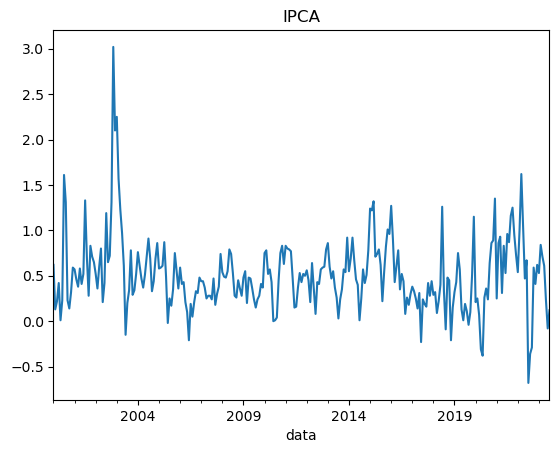

In [61]:
dados['ipca'].plot() 
plt.title('IPCA') 
plt.show()


### Teste de raiz unitária - ADF

In [64]:
result = adfuller(dados['ipca']) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:') 
for key, value in result[4].items(): 
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.000639
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


###### Série temporal é estacionária, pois a estatística do teste é menor do que todos os valores críticos e o valor-p é praticamente zero. 
###### Isso significa que podemos rejeitar a hipótese nula de que a série tem uma raiz unitária com um alto grau de confiança. 
###### Portanto, não há necessidade de aplicar diferenciação

### Análise de correlação FAC e FACP

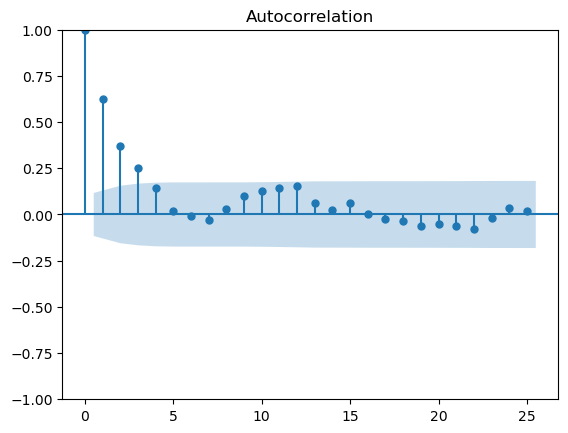

c:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


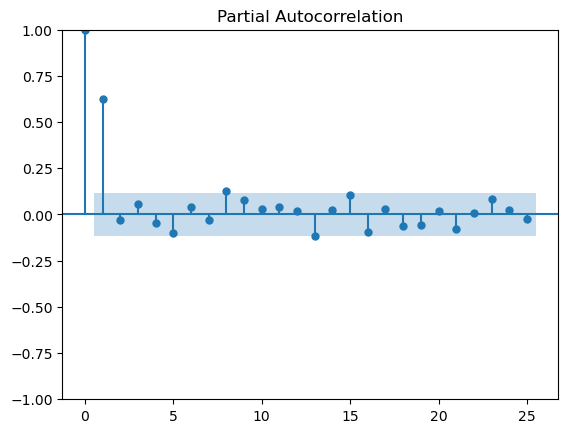

In [68]:
plot_acf(dados['ipca'].dropna()) 
plt.show() 
plot_pacf(dados['ipca'].dropna()) 
plt.show()

### Estimação

#### Critérios de informação

In [91]:
p_values = range(0, 5) 
q_values = range(0, 5) 
best_aic = float('inf') 
best_p = None 
best_q = None


#### Loop for para testar diferentes combinações de p e q

In [100]:
for p in p_values: 
    for q in q_values: 
        try: 
            # Ajustar o modelo ARIMA com os valores de p e q 
            model = SARIMAX(dados['ipca'], order=(p, 0, q), freq='M') 
            model_fit = model.fit() 
            # Calcular o AIC do modelo 
            aic = model_fit.aic 
            # Verificar se o AIC é menor do que o melhor AIC encontrado até agora 
            if aic < best_aic: 
                # Atualizar os valores de best_aic, best_p e best_q 
                best_aic = aic 
                best_p = p 
                best_q = q 
        except ValueError: 
                    # Tratar o erro de valor inválido que pode ocorrer quando o modelo não converge
                    print(f'Erro de convergência para ARIMA({p}, 0, {q})') 
                    # Continuar o loop para testar outras combinações 
        continue

Erro de convergência para ARIMA(0, 0, 0)
Erro de convergência para ARIMA(0, 0, 1)
Erro de convergência para ARIMA(0, 0, 2)
Erro de convergência para ARIMA(0, 0, 3)
Erro de convergência para ARIMA(0, 0, 4)
Erro de convergência para ARIMA(1, 0, 0)
Erro de convergência para ARIMA(1, 0, 1)
Erro de convergência para ARIMA(1, 0, 2)
Erro de convergência para ARIMA(1, 0, 3)
Erro de convergência para ARIMA(1, 0, 4)
Erro de convergência para ARIMA(2, 0, 0)
Erro de convergência para ARIMA(2, 0, 1)
Erro de convergência para ARIMA(2, 0, 2)
Erro de convergência para ARIMA(2, 0, 3)
Erro de convergência para ARIMA(2, 0, 4)
Erro de convergência para ARIMA(3, 0, 0)
Erro de convergência para ARIMA(3, 0, 1)
Erro de convergência para ARIMA(3, 0, 2)
Erro de convergência para ARIMA(3, 0, 3)
Erro de convergência para ARIMA(3, 0, 4)
Erro de convergência para ARIMA(4, 0, 0)
Erro de convergência para ARIMA(4, 0, 1)
Erro de convergência para ARIMA(4, 0, 2)
Erro de convergência para ARIMA(4, 0, 3)
Erro de convergê

#### Impressão do melhor modelo encontrado

In [101]:
print(f'Melhor ARIMA({best_p}, 0, {best_q}) AIC: {best_aic}')

Melhor ARIMA(2, 0, 1) AIC: 161.11448011127987


###### SARIMAX(2, 0, 1). Esse é o tipo e a ordem do seu modelo ARIMA, que usa combinações de termos autoregressivos e de média móvel para capturar as dinâmicas e os padrões da série temporal. 
###### Nesse caso, o modelo é SARIMAX, que significa Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors. Isso significa que o modelo pode incluir termos sazonais ou variáveis exógenas, além dos termos não sazonais. 
###### A ordem do modelo é (2, 0, 1), que significa que ele tem dois termos autoregressivos (AR), zero termos de diferenciação (I) e um termo de média móvel (MA). 
###### A ordem sazonal e as variáveis exógenas não foram especificadas nesse caso.

#### Resultado da estimação do modelo

In [106]:
model = SARIMAX(dados['ipca'], order=(2, 0, 1)) 
model_fit = model.fit()
print(model_fit.summary())

c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   ipca   No. Observations:                  283
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 -76.557
Date:                Sun, 20 Aug 2023   AIC                            161.114
Time:                        14:12:24   BIC                            175.696
Sample:                    01-01-2000   HQIC                           166.961
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6292      0.045     36.553      0.000       1.542       1.717
ar.L2         -0.6293      0.045    -14.117      0.000      -0.717      -0.542
ma.L1         -0.9936      0.018    -54.253      0.0

c:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


###### Log Likelihood: -76.557. Esse é o valor da função de verossimilhança logarítmica do seu modelo ARIMA, que mede o quão bem o modelo se ajusta aos seus dados. Quanto maior esse valor, melhor é o ajuste do modelo.

###### AIC: 161.114. Esse é o valor do critério de informação de Akaike (AIC) do seu modelo ARIMA, que é uma medida que penaliza modelos mais complexos e favorece modelos mais simples que se ajustam bem aos dados. Quanto menor esse valor, melhor é o modelo.

###### BIC: 175.696. Esse é o valor do critério de informação bayesiano (BIC) do seu modelo ARIMA, que é outra medida que penaliza modelos mais complexos e favorece modelos mais simples que se ajustam bem aos dados. Quanto menor esse valor, melhor é o modelo.

###### HQIC: 166.961. Esse é o valor do critério de informação de Hannan-Quinn (HQIC) do seu modelo ARIMA, que é mais uma medida que penaliza modelos mais complexos e favorece modelos mais simples que se ajustam bem aos dados. Quanto menor esse valor, melhor é o modelo.

###### Tipo Covariancia: opg. Esse é o tipo de matriz de covariância dos parâmetros estimados do seu modelo ARIMA, que indica como os parâmetros estão relacionados entre si e quão precisas são as suas estimativas. Nesse caso, o tipo é opg, que significa outer product of gradients (produto externo dos gradientes). Esse tipo usa uma aproximação numérica para calcular a matriz de covariância a partir dos gradientes da função objetivo.

###### coef: Essa é a coluna que mostra os valores dos coeficientes dos parâmetros estimados do seu modelo ARIMA, ou seja, os pesos que multiplicam cada termo autoregressivo ou de média móvel na equação do modelo. Nesse caso, os coeficientes são:

###### ar.L1: 1.6292. Esse é o coeficiente do primeiro termo autoregressivo (AR), que indica que a série atual depende positivamente do seu valor defasado em um período.
###### ar.L2: -0.6293. Esse é o coeficiente do segundo termo autoregressivo (AR), que indica que a série atual depende negativamente do seu valor defasado em dois períodos.
###### ma.L1: -0.9936. Esse é o coeficiente do primeiro termo de média móvel (MA), que indica que a série atual depende negativamente do erro defasado em um período.
###### sigma2: 0.0992. Esse é o coeficiente da variância do erro do modelo ARIMA, que indica o quão dispersos são os resíduos em torno da média.
###### std err: Essa é a coluna que mostra os erros padrão dos coeficientes dos parâmetros estimados do seu modelo ARIMA, ou seja, as medidas de incerteza das estimativas. Quanto menores esses valores, mais precisas são as estimativas.

###### z: Essa é a coluna que mostra os valores das estatísticas z dos coeficientes dos parâmetros estimados do seu modelo ARIMA, ou seja, as medidas de significância das estimativas. Quanto maiores esses valores em módulo, mais significativos são os parâmetros.

###### P>|z|: Essa é a coluna que mostra os valores-p dos coeficientes dos parâmetros estimados do seu modelo ARIMA, ou seja, as probabilidades de obter valores tão extremos ou mais extremos do que os observados, assumindo que a hipótese nula seja verdadeira. A hipótese nula é que o parâmetro é igual a zero, ou seja, que ele não tem efeito na série temporal. Quanto menores esses valores, mais evidência há de que a hipótese nula seja falsa.

###### [0.025 0.975]: Essa é a coluna que mostra os intervalos de confiança de 95% dos coeficientes dos parâmetros estimados do seu modelo ARIMA, ou seja, os intervalos que contêm os valores verdadeiros dos parâmetros com 95% de probabilidade. Quanto mais estreitos esses intervalos, mais precisas são as estimativas.

###### Ljung-Box (L1) (Q): 0.04. Esse é o valor da estatística Q do teste de Ljung-Box para a primeira defasagem dos resíduos do seu modelo ARIMA, ou seja, o teste que verifica se há autocorrelação nos resíduos. A autocorrelação nos resíduos indica que o modelo não capturou toda a informação da série temporal e pode ser melhorado. Quanto menor esse valor, mais evidência há de que há autocorrelação nos resíduos.

###### Prob(Q): 0.84. Esse é o valor-p do teste de Ljung-Box para a primeira defasagem dos resíduos do seu modelo ARIMA, ou seja, a probabilidade de obter um valor tão extremo ou mais extremo do que o observado, assumindo que a hipótese nula seja verdadeira. A hipótese nula é que não há autocorrelação nos resíduos. Quanto maior esse valor, mais evidência há de que a hipótese nula seja verdadeira.

###### Jarque-Bera (JB): 572.75. Esse é o valor da estatística JB do teste de Jarque-Bera para a normalidade dos resíduos do seu modelo ARIMA, ou seja, o teste que verifica se os resíduos têm uma distribuição normal. A normalidade dos resíduos indica que o modelo se ajustou bem aos dados e pode ser usado para fazer inferências e previsões. Quanto menor esse valor, mais evidência há de que os resíduos são normais.

###### Prob(JB): 0.00. Esse é o valor-p do teste de Jarque-Bera para a normalidade dos resíduos do seu modelo ARIMA, ou seja, a probabilidade de obter um valor tão extremo ou mais extremo do que o observado, assumindo que a hipótese nula seja verdadeira. A hipótese nula é que os resíduos são normais. Quanto menor esse valor, mais evidência há de que a hipótese nula seja falsa.

###### Heteroskedasticity (H): 0.92. Esse é o valor da estatística H do teste de heterocedasticidade dos resíduos do seu modelo ARIMA, ou seja, o teste que verifica se os resíduos têm variância constante ao longo do tempo. A homocedasticidade dos resíduos indica que o modelo não violou uma das suposições básicas da regressão e pode ser usado para fazer inferências e previsões. Quanto mais próximo esse valor for de um, mais evidência há de que os resíduos são homocedásticos.

###### Prob(H) (two-sided): 0.69. Esse é o valor-p do teste de heterocedasticidade dos resíduos do seu modelo ARIMA, ou seja, a probabilidade de obter um valor tão extremo ou mais extremo do que o observado, assumindo que a hipótese nula seja verdadeira. A hipótese nula é que os resíduos são homocedásticos. Quanto maior esse valor, mais evidência há de que a hipótese nula seja verdadeira.


##### A interpretação desses resultados é que os resíduos deste modelo ARIMA são homocedásticos, pois a estatística H é próxima de um e o valor-p é maior do que 0,05 (nível de significância usual). Isso significa que o seu modelo não violou a suposição de variância constante dos resíduos e pode ser usado para fazer inferências e previsões.

#### Gráfico de resíduos

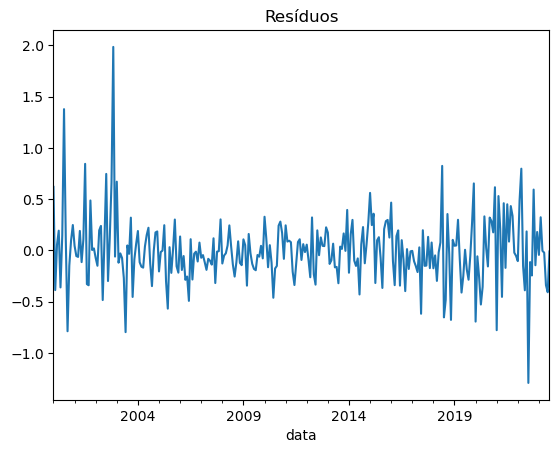

In [108]:
model_fit.resid.plot() 
plt.title('Resíduos') 
plt.show()

#### Diagnóstico gráfico do modelo

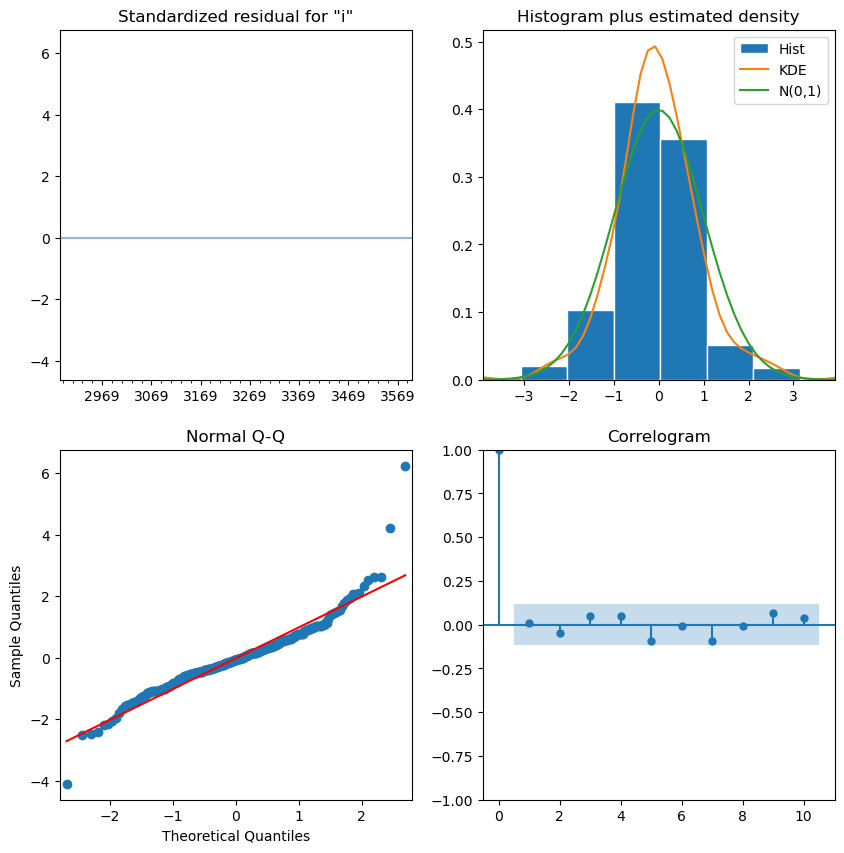

In [113]:

model_fit.plot_diagnostics(figsize=(10, 10))
plt.show()

In [110]:
#Teste de autocorrelação residual
print(model_fit.test_serial_correlation(method='ljungbox'))

[[[0.04284649 0.74405134 1.52770208 2.27784791 4.75389919 4.76085912
   7.20654596 7.22098254 8.46537885 8.93017641]
  [0.83601458 0.68933655 0.67589162 0.68480505 0.44664679 0.5748301
   0.40769604 0.512989   0.48801051 0.5387427 ]]]


In [117]:
table = tabulate(model_fit.test_serial_correlation(method='ljungbox'), headers=['Defasagem', 'Q', 'Valor-p', 'Graus de liberdade', 'Valor crítico']) 
print(table)

Defasagem                                                           Q
------------------------------------------------------------------  -----------------------------------------------------------------
[0.04284649 0.74405134 1.52770208 2.27784791 4.75389919 4.76085912  [0.83601458 0.68933655 0.67589162 0.68480505 0.44664679 0.5748301
 7.20654596 7.22098254 8.46537885 8.93017641]                        0.40769604 0.512989   0.48801051 0.5387427 ]


### Previsão

In [118]:
pred_historico = model_fit.predict(start='2000-01-01', end='2023-08-01')

#### Impressão das previsões

In [122]:
pred_novo = model_fit.forecast(steps=4)
pred_novo

2023-08-01    0.255204
2023-09-01    0.340277
2023-10-01    0.393802
2023-11-01    0.427474
Freq: MS, Name: predicted_mean, dtype: float64

#### Gráfico das previsões

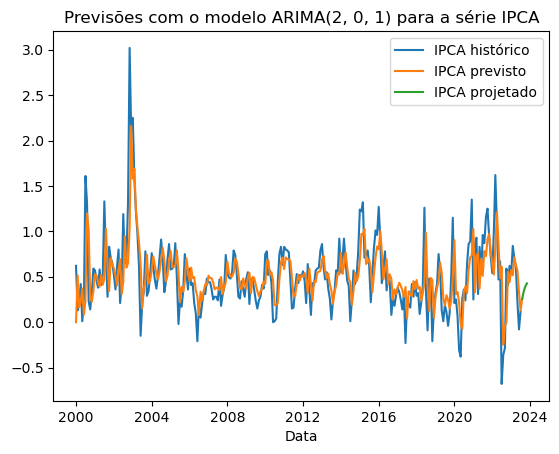

In [120]:
plt.plot(dados['ipca'], label='IPCA histórico') 
plt.plot(pred_historico, label='IPCA previsto') 
plt.plot(pred_novo, label='IPCA projetado') 
plt.title('Previsões com o modelo ARIMA(2, 0, 1) para a série IPCA') 
plt.legend() 
plt.xlabel('Data') 
plt.show()